In [28]:
import pandas as pd

df = pd.read_excel("/content/Online Retail.xlsx")

# --- Data Cleaning ---

df = df.dropna(subset=["CustomerID"])
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Description"] = df["Description"].str.strip().str.lower()
df["CustomerID"] = df["CustomerID"].astype(str)

# --- Data Preparation ---

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
basket = df.groupby("InvoiceNo")["Description"].apply(list)
customer_basket = df.groupby("CustomerID")["Description"].apply(list)

print("Transactions (InvoiceNo):", basket.shape[0])
print("Customers:", customer_basket.shape[0])

Transactions (InvoiceNo): 18532
Customers: 4338


In [29]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

transactions = basket.tolist()

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

transaction_matrix = pd.DataFrame(te_ary, columns=te.columns_)

print(transaction_matrix.shape)
print(transaction_matrix.head())


(18532, 3866)
   10 colour spaceboy pen  12 coloured party balloons  \
0                   False                       False   
1                   False                       False   
2                   False                       False   
3                   False                       False   
4                   False                       False   

   12 daisy pegs in wood box  12 egg house painted wood  \
0                      False                      False   
1                      False                      False   
2                      False                      False   
3                      False                      False   
4                      False                      False   

   12 hanging eggs hand painted  12 ivory rose peg place settings  \
0                         False                             False   
1                         False                             False   
2                         False                             False   
3           

In [30]:
import pandas as pd
from mlxtend.frequent_patterns import fpgrowth, association_rules

# --- FP-Growth: find frequent itemsets ---
frequent_itemsets = fpgrowth(
    transaction_matrix,
    min_support=0.01,
    use_colnames=True
)

# Sort by support
frequent_itemsets = frequent_itemsets.sort_values("support", ascending=False)
print(frequent_itemsets.head())

# --- Association Rules ---
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.0
)

rules = rules.sort_values("lift", ascending=False)
print(rules.head())

      support                              itemsets
0    0.106357  (white hanging heart t-light holder)
253  0.091895            (regency cakestand 3 tier)
88   0.086337             (jumbo bag red retrospot)
438  0.074412                       (party bunting)
7    0.074196       (assorted colour bird ornament)
                                           antecedents  \
701                          (regency tea plate green)   
700                           (regency tea plate pink)   
930                     (poppy's playhouse livingroom)   
927  (poppy's playhouse kitchen, poppy's playhouse ...   
648                            (regency milk jug pink)   

                                           consequents  antecedent support  \
701                           (regency tea plate pink)            0.014569   
700                          (regency tea plate green)            0.012087   
930  (poppy's playhouse kitchen, poppy's playhouse ...            0.013598   
927                     (po

In [31]:
import pandas as pd
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import silhouette_score

# --- Prepare RFM table ---
ref_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (ref_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

print(rfm.head())

X = rfm[["Recency", "Frequency", "Monetary"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- KMeans ---
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(X_scaled)

print(rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean())

score = silhouette_score(X_scaled, rfm["Cluster"])
print("Silhouette Score:", score)


  CustomerID  Recency  Frequency  Monetary
0    12346.0      326          1  77183.60
1    12347.0        2          7   4310.00
2    12348.0       75          4   1797.24
3    12349.0       19          1   1757.55
4    12350.0      310          1    334.40
            Recency  Frequency       Monetary
Cluster                                      
0         43.702685   3.682711    1359.049284
1        248.075914   1.552015     480.617480
2          7.384615  82.538462  127338.313846
3         15.500000  22.333333   12709.090490
Silhouette Score: 0.616212846765192


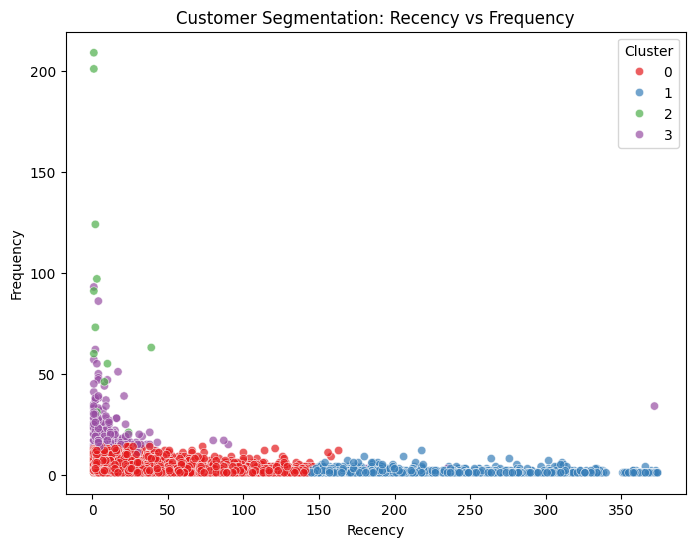

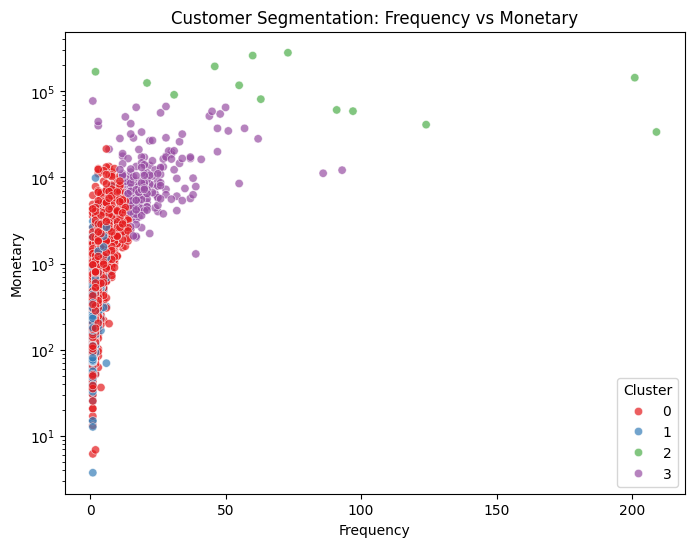

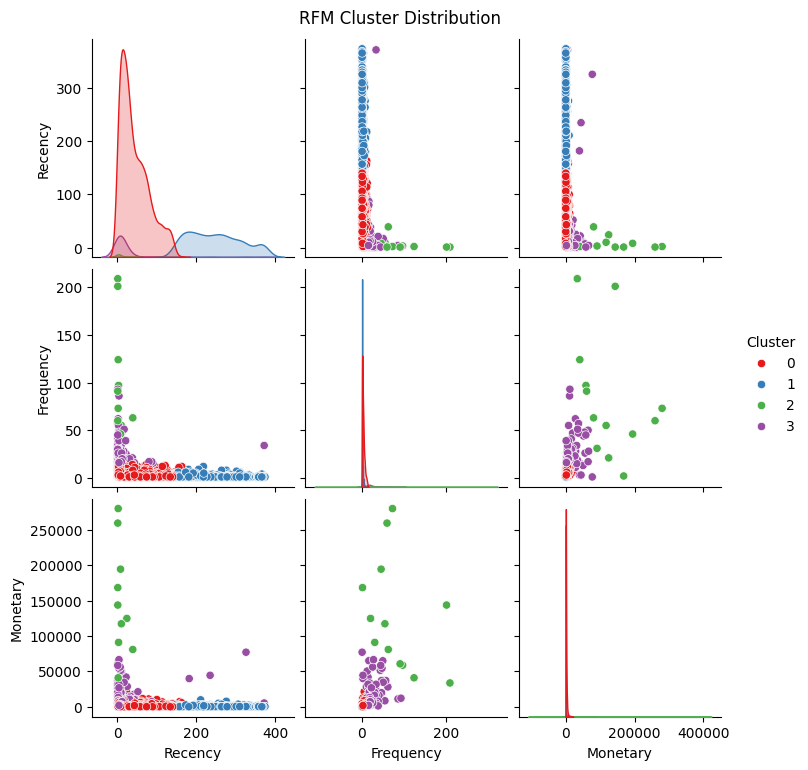

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


# --- Scatterplot: Recency vs Frequency ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=rfm, x="Recency", y="Frequency",
    hue="Cluster", palette="Set1", alpha=0.7
)
plt.title("Customer Segmentation: Recency vs Frequency")
plt.show()

# --- Scatterplot: Frequency vs Monetary ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=rfm, x="Frequency", y="Monetary",
    hue="Cluster", palette="Set1", alpha=0.7
)
plt.title("Customer Segmentation: Frequency vs Monetary")
plt.yscale("log")  # scale down monetary extremes
plt.show()

# --- Pairplot for all three RFM variables ---
sns.pairplot(
    rfm[["Recency","Frequency","Monetary","Cluster"]],
    hue="Cluster", palette="Set1"
)
plt.suptitle("RFM Cluster Distribution", y=1.02)
plt.show()


In [33]:
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

cluster_rules = {}

for cluster_id in rfm["Cluster"].unique():
    cust_ids = rfm.loc[rfm["Cluster"] == cluster_id, "CustomerID"]
    df_cluster = df[df["CustomerID"].isin(cust_ids)]

    basket_cluster = df_cluster.groupby("InvoiceNo")["Description"].apply(list)
    transactions = basket_cluster.tolist()

    if len(transactions) == 0:
        continue

    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    trans_matrix = pd.DataFrame(te_ary, columns=te.columns_)

    # --- FP-Growth ---
    frequent_itemsets = fpgrowth(trans_matrix, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

    # Store results
    cluster_rules[cluster_id] = rules.sort_values("lift", ascending=False).head(10)

print("Cluster 0 ")
print(cluster_rules[0])

print("Cluster 1 ")
print(cluster_rules[1])

print("Cluster 2 ")
print(cluster_rules[2])

print("Cluster 3 ")
print(cluster_rules[3])

Cluster 0 
                                            antecedents  \
1053                          (regency tea plate green)   
1052                           (regency tea plate pink)   
676                     (set/6 red spotty paper plates)   
677                       (set/6 red spotty paper cups)   
1060                            (regency milk jug pink)   
1061                         (regency sugar bowl green)   
686   (poppy's playhouse kitchen, poppy's playhouse ...   
691                      (poppy's playhouse livingroom)   
1051                          (regency tea plate green)   
1050                          (regency tea plate roses)   

                                            consequents  antecedent support  \
1053                           (regency tea plate pink)            0.013159   
1052                          (regency tea plate green)            0.010936   
676                       (set/6 red spotty paper cups)            0.014759   
677                    

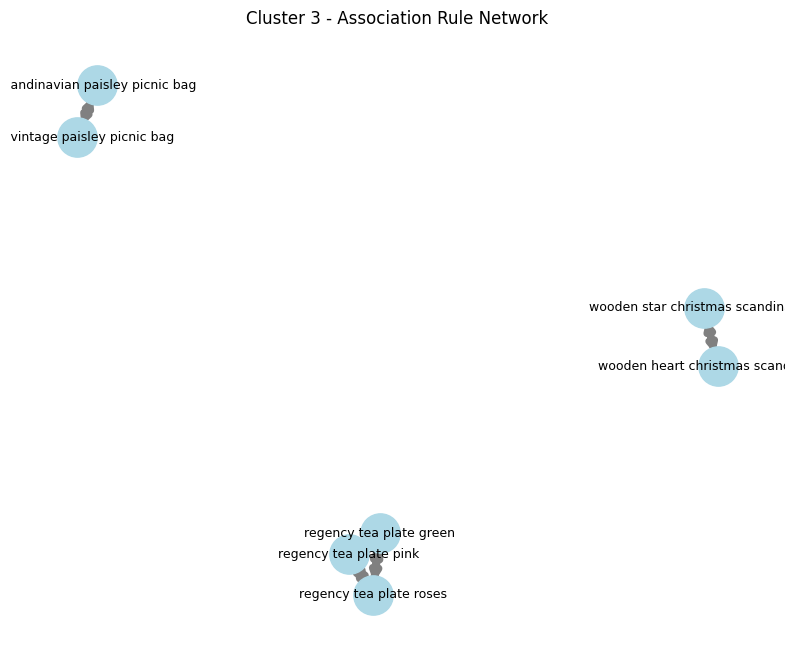

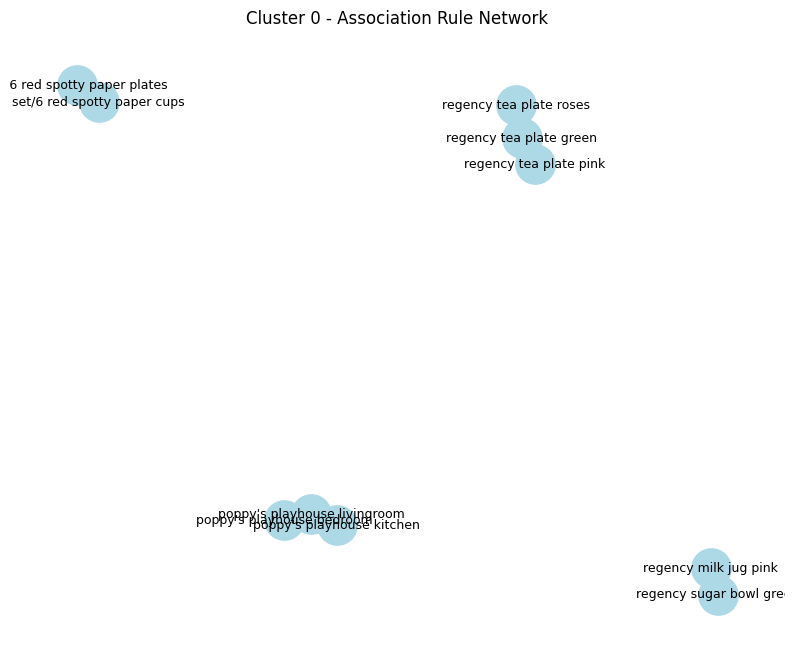

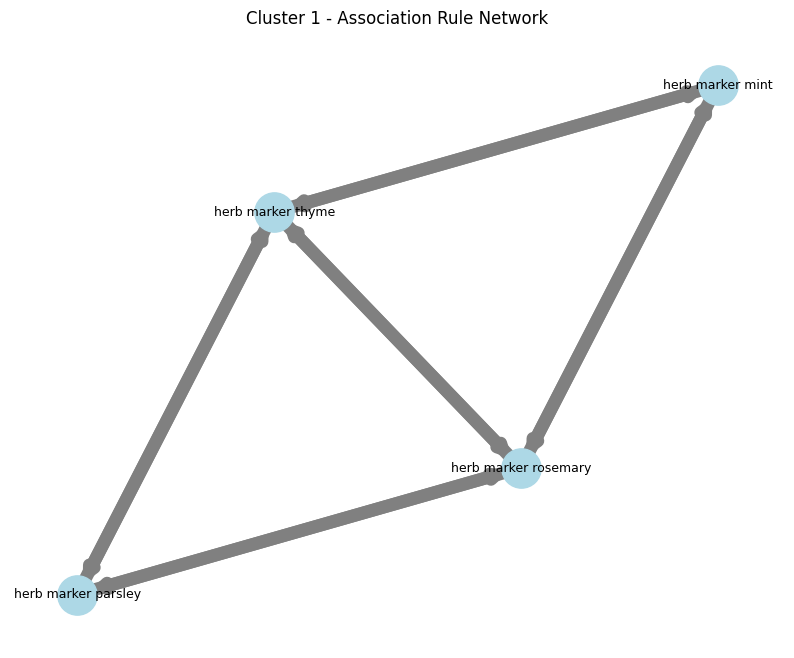

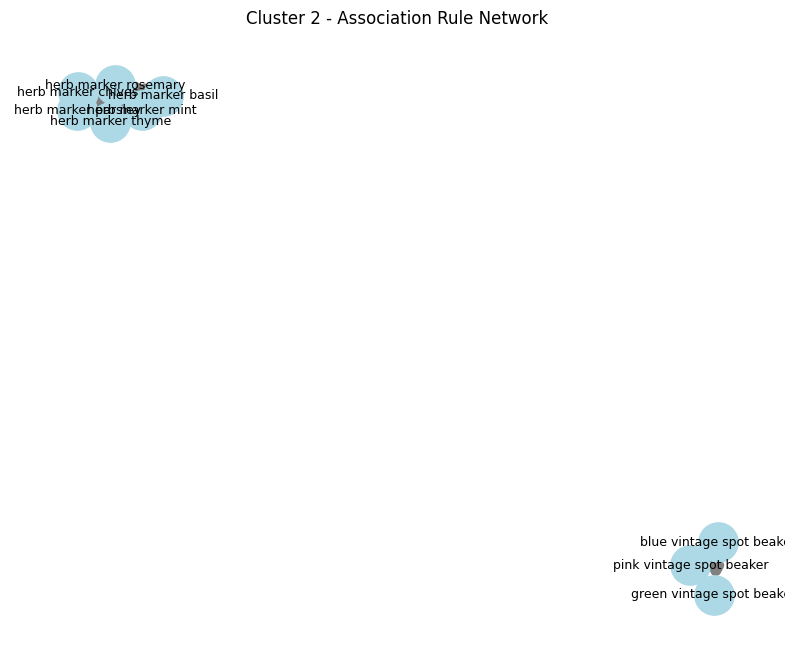

In [36]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def plot_rule_network(rules, cluster_id, top_n=15):
    rules = rules.sort_values("lift", ascending=False).head(top_n)

    G = nx.DiGraph()
    for _, row in rules.iterrows():
        antecedents = list(row["antecedents"])
        consequents = list(row["consequents"])
        for a in antecedents:
            for c in consequents:
                G.add_edge(a, c, weight=row["lift"], confidence=row["confidence"])

    pos = nx.spring_layout(G, k=0.5, iterations=50)

    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color="lightblue")
    nx.draw_networkx_labels(G, pos, font_size=9)
    nx.draw_networkx_edges(
        G, pos, arrowstyle="->", arrowsize=10,
        edge_color="gray", width=[d['weight']/10 for (_,_,d) in G.edges(data=True)]
    )

    plt.title(f"Cluster {cluster_id} - Association Rule Network")
    plt.axis("off")
    plt.show()

# --- Plot networks for all clusters ---
for cluster_id, rules in cluster_rules.items():
    if not rules.empty:
        plot_rule_network(rules, cluster_id)


**Business-facing summary**

Cluster 0 – Average

Behavior: Occasion-driven (tea plates, Christmas decor, picnic bags)

Strategy: Seasonal promotions, holiday discounts, themed offers


Cluster 1 – Inactive

Behavior: Low-cost, entry items (tea plates, paper cups, small decor)

Strategy: Win-back offers, discount bundles, starter packs


Cluster 2 – VIP

Behavior: High-value complete sets (herb markers, premium bundles)

Strategy: Bundle promotions, premium loyalty programs, stock management


Cluster 3 – Loyal

Behavior: Bundles + decor (herb markers, beakers, themed products)

Strategy: Upsell to VIP bundles, loyalty rewards, cross-selling kits